In [265]:
"""
BIMOLPES - Bimolecular Potential Energy Surface

Aims to sample the full 3D bimolecular potential energy suraface 
using DFT. Takes an input structure from a DFT optimsiation 
and goes from there

Currently just does single point energy (i.e. a rigid scan)

You need:
A DFT geometry of a single molecule optimised at some level of theory

You should:
Edit the cells here so your level of theory for the bimolpes matches your input geometry (RJM - could add this automatically)

You get:
Some data, some plots
"""

'\nBIMOLPES - Bimolecular Potential Energy Surface\n\nAims to sample the full 3D bimolecular potential energy suraface \nusing DFT. Takes an input structure from a DFT optimsiation \nand goes from there\n\nCurrently just does single point energy (i.e. a rigid scan)\n\nYou need:\nA DFT geometry of a single molecule optimised at some level of theory\n\nYou should:\nEdit the cells here so your level of theory for the bimolpes matches your input geometry (RJM add this automatically)\n\n'

In [266]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import re
import os
import glob
from scipy.interpolate import griddata

# these functions are lifted from PYGAUSS without modification:
def atomic_number_to_symbol(atomic_number):
    '''
    Simply returns the atomic symbol for a given element number (lazy!)
    '''
    element_symbols = [
        "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
        "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
        "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Ni", "Co", "Cu", "Zn",
        "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
        "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
        "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
        "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
        "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
        "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
        "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
        "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
        "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
    ]
    
    if 1 <= atomic_number <= len(element_symbols):
        return element_symbols[atomic_number - 1]
    else:
        return "Invalid Atomic Number"
    
def get_geometries(file_path):
    '''
    basic function that extracts any and all geometries present in a Gaussian output file.
    
    These can be the output of an optimisation (e.g. all_geometries[-0], the last geometry)
    They might be all geometries in an optimisation of some sort
    
    Args:
    file_path - the file you want to read
    
    Returns:
    all_geometries - the extracted geometry data from the "standard orientation" tables.
    '''

    all_geometries = [] # List to store the extracted lines

    with open(file_path, 'r') as file:
        file_text = file.read()
        match_start = [m.start() for m in re.finditer('Standard orientation',file_text)]
        match_finish = [n.start() for n in re.finditer('Rotational constants',file_text)]

    for m in range(len(match_start)):
        all_geometries.append(file_text[match_start[m]:match_finish[m]])
        
    print('I found ' + str(len(all_geometries)) + ' geometries in total in ' + file_path + '\n')

    return all_geometries

def generate_coords(extracted_geometry):
    '''
    takes extracted geometry from get_geometries and polishes it so we can reuse it in a new input .gjf file
    
    Args:
    extracted_geometry - our extracted geometry (just a single geometry!) from get_geometries.
    
    Returns
    coords - .gjf formatted coordinates.
    '''
    
    lines = extracted_geometry.strip().split('\n')
    data_lines = lines[5:-1]  # Skipping header and footer lines

    atomic_data = []
    coords = [] # empty array for coordinate data
    # Extract atomic number, element symbol, and coordinates
    for line in data_lines:
        columns = line.split()
        atomic_number = int(columns[1])
        element_symbol = atomic_number_to_symbol(atomic_number)
        x, y, z = float(columns[3]), float(columns[4]), float(columns[5])
        atomic_data.append((element_symbol, x, y, z))

    # Print the extracted data
    for symbol, x, y, z in atomic_data:
        coords.append(f"{symbol}         {x} {y} {z}")
        
    return(coords)

def read_gaussian_route_section(file_path):
    '''
    Reads the route-section of a Gaussian .log/.out file
    and returns the route options as a list
    
    Args:
        file_path - file path of the .log/.out file to read
        
    Returns:
        input_options - a list of input options
    '''
    
    input_options=[]
    with open(file_path, 'r') as log_file:
        start_flag = False
        for line in log_file:
            line = line.strip()
            if line.startswith('----------------------------------------------------------------------'):
                if start_flag:
                    break  # Stop processing after the first set of input options
                start_flag = True
            elif start_flag:
                options = line.split()
                input_options.extend(options)

    return(input_options) 

In [267]:
# these are new functions built for bimolpes:
"""
anticipated functions:

gen_grid - build an xyz grid to increment over
update_coords - 

liftable functions:
write_gjf: borrowed from PyGauss with some tweaks
write_sge: borrowed from PyGauss and modified
"""
def gen_grid(dx, dy, dz, res = 0.25, full_dz = False):
    """
    Make a grid 
    """
    
    x_range = np.arange(-dx, dx + (res if dx != 0 else res/2), res)
    y_range = np.arange(-dy, dy + (res if dy != 0 else res/2), res)
    
    if full_dz == True: # do both sides/faces of the molecule pair in Z
        z_range = np.arange(-dz, dz + (res if dz != 0 else res/2), res)
        
    if full_dz == False:  # do just one sides/faces of the molecule pair in Z
        z_range = np.arange(0, dz + (res if dz != 0 else res/2), res)
        
    grid = []
    for x in x_range:
        for y in y_range:
            for z in z_range:
                grid.append((x, y, z))

    return grid

def add_fragment_label(geometry, fragment_number=1):
    """
    Adds "(Fragment={fragment_number})" after the atomic symbol in each line of the geometry.

    :param geometry: List of strings representing the atoms and their coordinates.
    :return: Updated geometry with "(Fragment=1)" labels as a list of strings.
    """
    updated_geometry = []

    for line in geometry:
        parts = line.split()
        if len(parts) == 4:
            atom, x, y, z = parts[0], parts[1], parts[2], parts[3]
            atom_with_fragment = f"{atom}(Fragment={fragment_number})"
            new_line = f"{atom_with_fragment} {x} {y} {z}"
            updated_geometry.append(new_line)

    return updated_geometry

def adjust_coords(geometry, dx=0, dy=0, dz=0):
    """
    Adjusts the geometry by adding/subtracting deltas to the x, y, and z coordinates.

    :param geometry: List of strings representing the atoms and their coordinates.
    :param dx: Value to add/subtract from the x coordinate.
    :param dy: Value to add/subtract from the y coordinate.
    :param dz: Value to add/subtract from the z coordinate.
    :return: Adjusted geometry as a list of strings.
    """
    adjusted_geometry = []

    for line in geometry:
        parts = line.split()
        if len(parts) == 4:
            atom, x, y, z = parts[0], float(parts[1]), float(parts[2]), float(parts[3])
            x_new = x + dx
            y_new = y + dy
            z_new = z + dz
            new_line = f"{atom} {x_new:.6f} {y_new:.6f} {z_new:.6f}"
            adjusted_geometry.append(new_line)

    return adjusted_geometry

def write_gjf(frag1, 
              frag2,
              displacement,
              nproc=2, 
              vmem=4, 
              functional='B3LYP',
              basis = 'cc-pVTZ',
              options ='EmpiricalDispersion=GD3BJ counterpoise=2',
              file_name='test'):
    
    with open(file_name + '.gjf', 'w') as f:
        f.write('%nprocshared=' + str(nproc) + '\n')
        f.write('%mem=' + str(vmem) + 'GB\n')
        f.write('#T ' + functional + ' ' + basis + ' ' + options + '\n\n') # terse output!
        f.write(displacement + '\n\n')
        f.write('0 1\n')
        
        for i, atom in enumerate(frag1 + frag2):
            f.write(atom)
            f.write('\n')
        f.write('\n\n')
    return file_name

def make_sge_job(filename='noname', vmem=4, nproc=2, startjob=0, endjob=0):
    """
    Generate a job script for running a Gaussain job on ARC (the UoL compute clusters).
    
    Args:
        filename (str): The name of the job script file (default: 'noname').
        vmem (str): The virtual memory allocation for each job in GB(default: '8').
        nproc (int): The number of processors to use for each job (default: 8).
        startjob (int): The starting index of the task array (default: 0).
        endjob (int): The ending index of the task array (default: 0).

    Returns:
        None
    """
    
    # Decide if we have a task array (i.e. multiple .gjf files) 
    if startjob + endjob == 0:
        Multiple = False
        
    if startjob + endjob != 0:
        Multiple = True
        
        
    with open(filename + '.sh', 'w') as f:
        f.write('#$ -cwd \n')
        f.write('#$ -V\n')
        f.write('#$ -l h_rt=48:00:00\n')
        f.write('#$ -l h_vmem=' + str(vmem) + 'G\n')
        f.write('#$ -pe smp ' + str(nproc) + '\n')
        f.write('#$ -l disk=5G\n')
        if Multiple:
            f.write('#$ -t ' + str(startjob) + '-' + str(endjob) + '\n')  # Create a task array

        f.write('module add gaussian\n')
        f.write('export GAUSS_SCRDIR=$TMPDIR\n')
        f.write('g16 ' + filename + ('_$SGE_TASK_ID' * Multiple) + '.gjf\n')
        f.write('rm *core* \n')
        
    return    

In [268]:
def distance(point1, point2):
    """
    Calculate the distance between two points in xyz.
    """
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2 + (point1[2] - point2[2]) ** 2) ** 0.5

def check_fragments_too_close(frag1, frag2, min_cutoff=2):
    """
    Check if any atoms in two fragments are too close based on the cutoff distance.

    Parameters:
    frag1 (list): The list of atoms and their coordinates for the first fragment.
    frag2 (list): The list of atoms and their coordinates for the second fragment.
    cutoff (float): The cutoff distance to consider atoms too close.

    Returns:
    bool: True if any atoms are too close, False otherwise.
    """
    for atom1 in frag1:
        for atom2 in frag2:
            coords1 = tuple(map(float, atom1.split()[1:4]))
            coords2 = tuple(map(float, atom2.split()[1:4]))
            if distance(coords1, coords2) < min_cutoff:
                return True
    return False

def check_fragments_too_far(frag1, frag2, max_cutoff=5):
    """
    Check if any atoms in two fragments are too close based on the cutoff distance.

    Parameters:
    frag1 (list): The list of atoms and their coordinates for the first fragment.
    frag2 (list): The list of atoms and their coordinates for the second fragment.
    cutoff (float): The cutoff distance to consider atoms too close.

    Returns:
    bool: True if any atoms are too close, False otherwise.
    """
    for atom1 in frag1:
        for atom2 in frag2:
            coords1 = tuple(map(float, atom1.split()[1:4]))
            coords2 = tuple(map(float, atom2.split()[1:4]))
            if distance(coords1, coords2) <= max_cutoff:
                return False 
    return True  

def clean_path(filename):
    """
    Remove files matching 'filename*.log' where * is an integer and 'filename.sh' in the current directory.
    """
    for log_file in glob.glob(filename.split('.')[0] + '*.gjf'):
        os.remove(log_file)
        #print(f"Removed: {log_file}")

    for sh_file in glob.glob(filename.split('.')[0] + '*.sh'):
        os.remove(sh_file)
        #print(f"Removed: {sh_file}")


In [269]:
def create_grid(filename, dx, dy, dz, full_dz = False, res = 0.25, min_dist = 2, max_dist = 8):
    '''
    Function to create a grid of points which we use as translation vectors for our second molecule
    For each point on the grid we offset molecule 2 by this much, allowing us to scan across all 3 dimensions
    
    dx        - min/max displacement in x (goes from -dx to dx)
    dy        - min/max displacement in y (goes from -dy to dy)
    dz        - min/max displacement in z (goes from -dz to dz)
    full_dx   - boolean; if False dz goes from 0 to dz. if true, from -dz to dz. Essentially clips to one hemisphere.
    min_dist  - cutoff if any atom on mol1 is this close to any atom in mol2 then this set of coordinates is rejected
    max_dist  - cutoff if any atom on mol1 is this far to any atom in mol2 then this set of coordinates is rejected
    
    returns:
    gjf files - Gaussian input files, one for each accepted set of translations
    sh file   - SGE file for executing on ARC3/4
    
    '''
    clean_path(filename) # tidy directory
    
    geo = generate_coords(get_geometries(filename)[-1])
    grid = gen_grid(dx, dy, dz, res = res, full_dz = full_dz)
    
    print(f'Using a grid of x={[-dx, dx]} y={[-dy,dy]} z={[(-dz if full_dz else 0, dz)]} res={res}; size={np.product(np.shape(grid))}')
    if full_dz == True:
        print(f'Using full z-sweep (both hemispheres)')
    count = 1 # start from 1 as we'll use SGE 
    frag1 = add_fragment_label(geo,1)
    
    for gri in grid:
        frag2 = add_fragment_label(adjust_coords(geo,dx=gri[0],dy=gri[1],dz=gri[2]),2)
        displacement = f'dx={gri[0]}/dy={gri[1]}/dz={gri[2]}'

        if not check_fragments_too_close(frag1, frag2, min_cutoff=min_dist):
            if not check_fragments_too_far(frag1, frag2, max_cutoff=max_dist):
                displacement = f'dx={gri[0]}/dy={gri[1]}/dz={gri[2]}'
                file_name = filename.split('.')[0] + '_' + str(count)
                write_gjf(frag1, frag2, displacement=displacement, file_name=file_name)
                count += 1
    print(f'Total of {count} geometries after cutoff')
    
    make_sge_job(filename = filename.split('.')[0], startjob=1, endjob=count) # make the SGE job

In [270]:
'''
Functions for analysis

extract_complexation_energy - gets the corrected complexation energy
extract_final energy        - gets the SCF energy
extract_translation_coor... - gets the translation coordinates from the header
find_log_files              - get a list of all log files in the given directory
'''
    
def extract_complexation_energy(log_file_path):
    '''
    Return the complexation energy (in kcal mol-1) from a Gaussian .log file
    '''
    complexation_energy = None
    with open(log_file_path, 'r') as file:
        for line in file:
            if "complexation energy" in line:
                parts = line.split('=')
                try:
                    energy_str = parts[1].split()[0]  # Get the first part after '=', which should be the energy value
                    complexation_energy = float(energy_str.strip())
                except (IndexError, ValueError):
                    print("Error parsing complexation energy from line:", line)
    return complexation_energy

def extract_final_energy(log_file_path):
    '''
    Return the SCF energy from a Gaussian .log file (in Ha)
    '''
    final_energy = None
    with open(log_file_path, 'r') as file:
        for line in file:
            if line.startswith(" Counterpoise corrected energy ="):
                parts = line.split('=')
                try:
                    final_energy = float(parts[1].strip())
                except (IndexError, ValueError):
                    # Handle the case where parsing fails
                    print("Error parsing energy from line:", line)
                    final_energy = None
    return final_energy

def extract_translation_coordinates(file_path):
    '''
    Read the translation coordinates from the Gaussian log file header (We wrote these earlier for this reason)
    '''
    coordinates = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip().startswith('dx='):
                match = re.search(r'dx=(-?\d+\.?\d*)/dy=(-?\d+\.?\d*)/dz=(-?\d+\.?\d*)', line.strip()) # Use regex to find the dx, dy, dz values
                if match:
                    dx, dy, dz = map(float, match.groups())
                    coordinates.append((dx, dy, dz))
    return coordinates

def find_log_files(directory):
    # finds .log files and NOWT ELSE
    log_files = []
    for file in os.listdir(directory):
        if file.endswith(".log"):
            log_files.append(os.path.join(directory, file))
    return log_files

def process_files(path = os.getcwd(), method=0):
    '''
    Wrapper function - uses the tools above to process output
    
    Parameters:
    path   - place to get files from
    method - if 0 = use SCF energy, if =1 get complexation energy
    
    Returns:
    data - nested list of data [dx, dy, dz, energy]
    '''
    files = find_log_files(os.getcwd())
    data = []
    for file in files:
        coords = extract_translation_coordinates(file)
        if method == 0:
            energy = extract_final_energy(file)
        if method == 1:
            energy = extract_complexation_energy(file)

        if coords != None and energy != None:
            for coord in coords:
                data.append([coord[0], coord[1], coord[2], energy])
    return data

def shape_data(data):
    '''
    just shape the data returned by process_files() for plotting
    
    Parameters:
    data      - the data variable to use
    
    Returns:
    dx (y,z)  - x/y/z translation coordinates
    e_values  - raw energy
    de_values - delta energy
    '''
    
    dx_values = [row[0] for row in data]
    dy_values = [row[1] for row in data]
    dz_values = [row[2] for row in data]
    dyz_values = np.sqrt(np.array([row[1] for row in data])**2 + np.array([row[2] for row in data])**2)
    e_values = [row[3] for row in data]
    de_values = e_values - np.min(e_values)
    
    return dx_values, dy_values, dz_values, dyz_values, e_values, de_values

In [281]:
# use this to run the function that generates our input files
#here dx etc are our spatial limits; res is our resolution, min/max_dist are our spatial cutoffs

create_grid(filename = 'rm734.log', dx = 20.0, dy = 7.0, dz = 5, res = 0.5, full_dz = False, min_dist = 3, max_dist = 5)

# at this point, zip the .gjf files and .sh file and run them on ARC4 (be patient)

I found 1 geometries in total in rm734.log

Using a grid of x=[-20.0, 20.0] y=[-7.0, 7.0] z=[(0, 5)] res=1; size=11070
Total of 1029 geometries after cutoff


In [199]:
# yer jobs have run. Zip the .logs (zip -R foo *.log on UNIX), download em, unzip, and run this (setting path=!)
process_files(path=os.getcwd(),method=0)
dx_values, dy_values, dz_values, dyz_values, e_values, de_values = shape_data(data) # shape that data
# you can now plot stuff

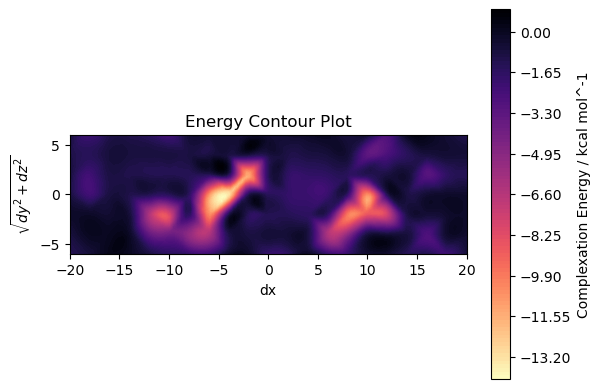

In [255]:
def make_contour_plot(x_values, y_values, z_values):
    %matplotlib inline
    xi = np.linspace(min(x_values), max(x_values), 100)
    yi = np.linspace(min(y_values), max(y_values), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate z_values onto the grid defined by xi and yi
    zi = griddata((x_values, y_values), z_values, (xi, yi), method='cubic')

    plt.figure()
    # Create contour plot
    contour = plt.contourf(xi, yi, zi, levels=100, cmap='magma_r')
    plt.colorbar(contour, label='Complexation Energy / kcal mol^-1')
    plt.xlabel('dx')
    plt.ylabel('$\sqrt{dy^2 + dz^2}$')
    plt.title('Energy Contour Plot')

    # Use 'equal' aspect ratio to maintain scaling on x and y axes
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
make_contour_plot(dx_values,dy_values,e_values)

<IPython.core.display.Javascript object>


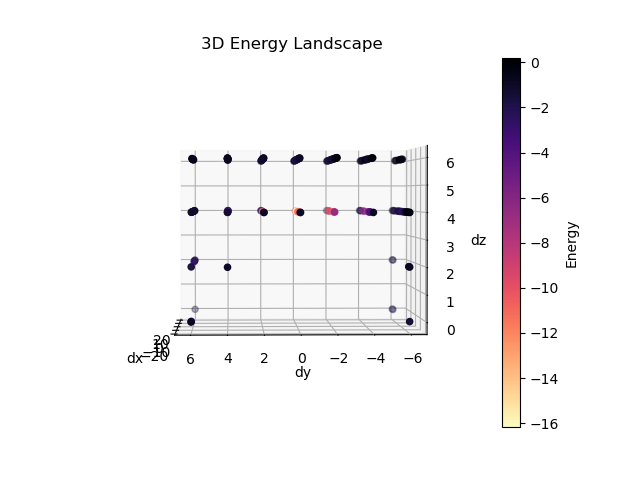

In [225]:
def make_volumetric_plot(dx_values,dy_values,dz_values,e_values):
    '''
    Do some 3D plotting
    '''
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(dx_values, dy_values, dz_values, c=e_values, cmap='magma_r')
    plt.colorbar(sc, label='Energy')
    ax.set_xlabel('dx')
    ax.set_ylabel('dy')
    ax.set_zlabel('dz')
    plt.title('3D Energy Landscape')
    plt.show()
    
make_volumetric_plot(dx_values,dy_values,dz_values,e_values)